In [1]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import pandas as pd

In [2]:
def val(P,x):
    return P[0]+P[1]*x+P[2]*x*x
def grad(P,x):
    return P[1]+P[2]*2*x

seed=1


<IPython.core.display.Javascript object>


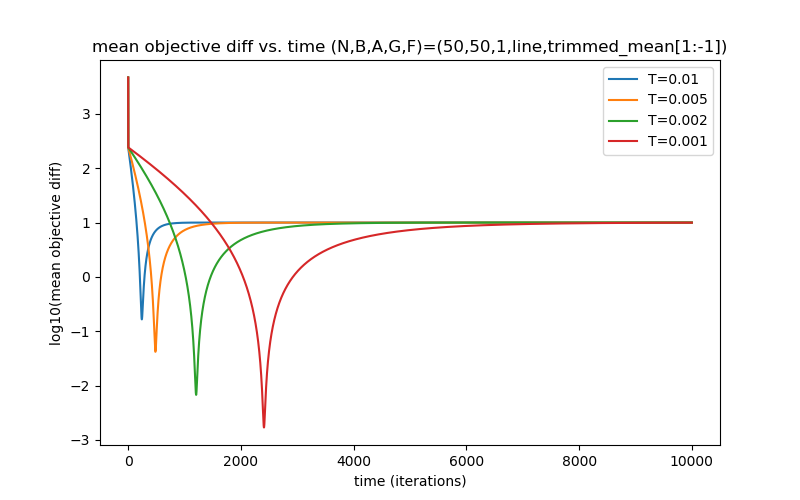

50,50,1,0.01,1,2871.0704185410614,2881.092599922205
50,50,1,0.005,1,2871.0704185410614,2881.0732955923745
50,50,1,0.002,1,2871.0704185410614,2881.101919711255
50,50,1,0.001,1,2871.0704185410614,2881.0442567186096


In [147]:
#parameters/other variables to adjust
N,B,A,ITER,F=50,50,1,10000,(lambda x:np.mean(x[1:-1]))
graph=[[] for i in range(N)]
for i in range(N):
    for j in range(max(0,i-B),min(i+B+1,N)):
        graph[i].append(j)
#     for d in range(-B,B+1):
#         graph[i].append((i+d)%N)
for a in range(A):
    graph.append([i for i in range(N)])
    for i in range(N):
        graph[i].append(len(graph)-1)

#start of actual DGD
seed=1
print('seed='+str(seed))
rnd.seed(seed)
Ps=[]
for i in range(N):
    a=rnd.uniform(0,1)
    v=rnd.uniform(-100,100)
    #(ax-v)^2=a^2x^2-2avx+v^2
    Ps.append([v*v,-2*a*v,a*a])
tP=[0 for i in range(3)]
for P in Ps:
    for i in range(3):
        tP[i]+=P[i]
for i in range(3):
    tP[i]/=N
optx=-tP[1]/(2*tP[2])
optval=val(tP,optx)
locs0=[rnd.uniform(-200,200) for i in range(N)]

fig,axs=plt.subplots(1,1,figsize=(8,5))
'''axs[1].set_title('functions')
axs[1].set_xlabel('x')
axs[1].set_ylabel('P_i,tP')
tmp=np.linspace(-200,200,100)
for P in Ps:
    axs[1].plot(tmp,val(P,tmp),alpha=0.1)
axs[1].plot(tmp,val(tP,tmp),linewidth=3)'''
if not(isinstance(axs,list)):
    axs=[axs]
axs[0].set_title('mean objective diff vs. time (N,B,A,F)=({},{},{},trimmed_mean[1:-1])'.format(N,B,A))
axs[0].set_xlabel('time (iterations)')
axs[0].set_ylabel('log10(mean objective diff)')

for T in [0.01,0.005,0.002,0.001]:
    locs=locs0
    locss=[locs]
    for rep in range(ITER):
        receivedVals=[[] for i in range(N)]
        for i in range(N+A):
            for j in graph[i]:
                if j<N:
                    receivedVals[j].append(locs[i] if i<N else 1000000)
                #                                              ^^^^^^^
                #basic adversary: always send the same big number to all neighbors
                #if "always super high": 1000000
                #if "always super low": -1000000
                #if "half high/half low": (1000000 if j<N/2 else -1000000)
        for i in range(N):
            receivedVals[i].sort()
        nlocs=[F(receivedVals[i])-T*grad(Ps[i],locs[i]) for i in range(N)]
        locs=nlocs
        locss.append(locs)
    meanscr=np.mean([val(tP,locss[ITER][i]) for i in range(N)])
    line='{},{},{},{},{},{},{}'.format(N,B,A,T,seed,optval,meanscr)
    print(line)
    axs[0].plot([np.log10(np.mean([val(tP,locss[t][i]) for i in range(N)])-optval) for t in range(ITER+1)],label='T='+str(T))
    #axs[1].scatter(x=locss[ITER],y=[val(tP,v) for v in locss[ITER]],s=5,c='black')
axs[0].legend()
fig.savefig('tmp',bbox_tight=True)